# Example DataScience Project

#### Client: 

My Flower Shop

#### Ask: 

Need to send out a catalog. Would like to know who to send it to.

#### One translation: 

Can we classify people according to whether they're likely to reorder?

## Notebook Setup

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

sns.set_theme()
sns.set_style('darkgrid')

%matplotlib inline

---

## Read in Data

In [2]:
datafile_name = '../data/flowershop_data.csv'

In [3]:
# print out the first few lines of the datafile, looks like standard csv with a header and dates
!head -5 {datafile_name}

lastname,purchase_date,stars,price,favorite_flower
PERKINS,2017-04-08,5,19.599885954165785,iris
ROBINSON,2017-01-01,5,37.98390361682093,
WILLIAMSON,2017-03-20,4,19.339137911467354,carnation
ROBINSON,2017-04-12,5,18.140615754070392,lilac


In [4]:
# read in data, note the number of rows and columns
df = pd.read_csv('../data/flowershop_data.csv', header=0, parse_dates=True)
print('{:d} rows, {:d} columns'.format(*df.shape))

1000 rows, 5 columns


In [5]:
# use head to make sure the data was read correctly
df.head()

,lastname,purchase_date,stars,price,favorite_flower
0,PERKINS,2017-04-08,5,19.599886,iris
1,ROBINSON,2017-01-01,5,37.983904,NaN
2,WILLIAMSON,2017-03-20,4,19.339138,carnation
3,ROBINSON,2017-04-12,5,18.140616,lilac
4,RHODES,2017-03-24,1,22.179522,carnation


---

## Evaluate and Clean Variables

In [6]:
# use info to evaluate missing values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lastname         1000 non-null   object 
 1   purchase_date    1000 non-null   object 
 2   stars            1000 non-null   int64  
 3   price            978 non-null    float64
 4   favorite_flower  822 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 39.2+ KB


---

### Evaluate and Clean: Stars

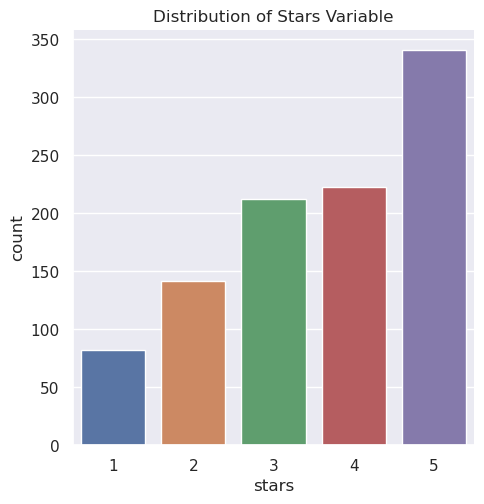

In [7]:
# plot histogram for stars
sns.catplot(x='stars',kind='count',data=df);
plt.title('Distribution of Stars Variable');

In [8]:
# an awful lot of 5s
# get highest name counts
df[df.stars == 5].lastname.value_counts().head()

ROBINSON    135
DANIELS       9
CALDWELL      8
JOHNSTON      6
JACOBS        6
Name: lastname, dtype: int64

In [9]:
# get differences in mean stars by name
robinson_mean = df[df.lastname == 'ROBINSON'].stars.mean()
other_mean = df[df.lastname != 'ROBINSON'].stars.mean()
robinson_mean_diff = robinson_mean - other_mean
print(f'robinson mean stars: {robinson_mean:0.2f}')
print(f'other mean stars   : {other_mean:0.2f}')
print(f'difference in mean : {robinson_mean_diff:0.2f}')

robinson mean stars: 4.23
other mean stars   : 3.43
difference in mean : 0.80


In [10]:
# get counts for names
n_robinson = len(df[df.lastname == 'ROBINSON'])
n_other = len(df) - n_robinson
print('n_robinson: {}'.format(n_robinson))
print('n_other   : {}'.format(n_other))

n_robinson: 208
n_other   : 792


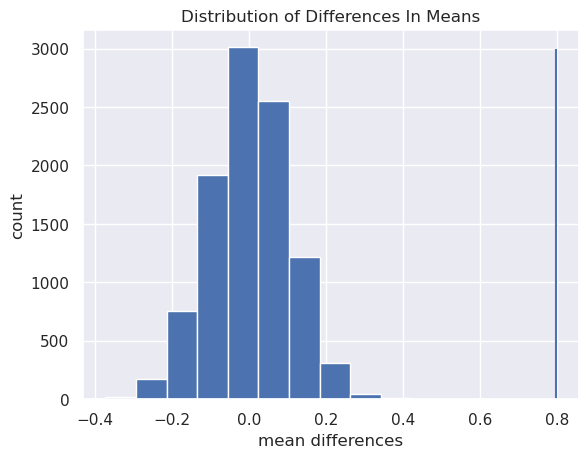

In [11]:
# do a permutation test to test for significance of difference

stars = df.stars.values
mean_diffs = []

for i in range(10000):
    perm = np.random.permutation(stars)
    mean_1 = np.mean(perm[:n_robinson])
    mean_2 = np.mean(perm[n_robinson:])
    mean_diffs.append(mean_1-mean_2)

plt.hist(mean_diffs);
plt.vlines(x=robinson_mean_diff, ymin = 0, ymax = 3000);
plt.xlabel('mean differences');
plt.ylabel('count');
plt.title('Distribution of Differences In Means');

In [12]:
# calculate the p-value
p = sum(np.abs(mean_diffs) >= np.abs(robinson_mean_diff)) / len(mean_diffs)
print(p)

0.0


**NOTE**: Getting rid of the records with lastname ROBINSON as the count of 5 stars from them seems suspiciously high relative to the rest of the sample.

In [13]:
# drop rows with lastname ROBINSON
df = df[df.lastname != 'ROBINSON']

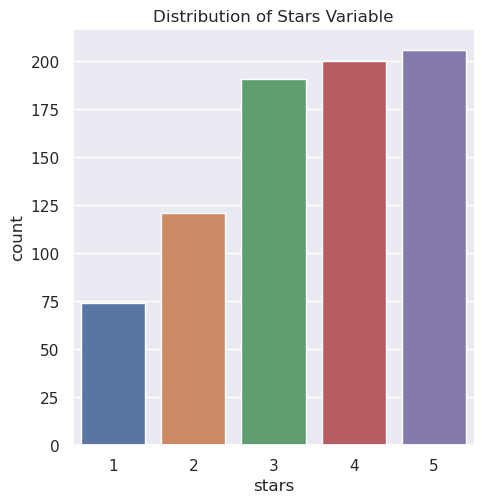

In [14]:
# plot again and notice the change in distiribution
sns.catplot(x='stars', kind='count', data=df);
plt.title('Distribution of Stars Variable');

In [15]:
# Reprinting .info(), note we still have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 998
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lastname         792 non-null    object 
 1   purchase_date    792 non-null    object 
 2   stars            792 non-null    int64  
 3   price            772 non-null    float64
 4   favorite_flower  654 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 37.1+ KB


---

### Evaluate and Clean Price

In [16]:
print(f'proportion of rows with missing price: {sum(df.price.isna()) / len(df):0.3f}')

proportion of rows with missing price: 0.025


In [17]:
# before dealing with missing prices, check distribution
df.price.describe()

count    772.000000
mean      23.720669
std       11.154642
min        7.621566
25%       18.596314
50%       20.226653
75%       38.837663
max       42.996317
Name: price, dtype: float64

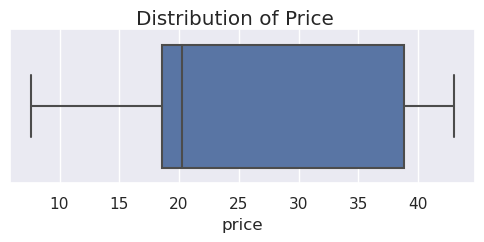

In [18]:
fig,ax = plt.subplots(1,1,figsize=(6,2))
sns.boxplot(df.price);
fig.suptitle('Distribution of Price');

In [19]:
# create new column encoding missing price
df['price_missing'] = df.price.isna()
print(f'proportion of price missing: {sum(df.price_missing)/len(df):0.3f}')

proportion of price missing: 0.025


In [20]:
# fill price with mean
df['price'] = df.price.fillna(df.price.mean())

In [21]:
# check to make sure we're no longer missing data
assert df.price.isna().sum() == 0

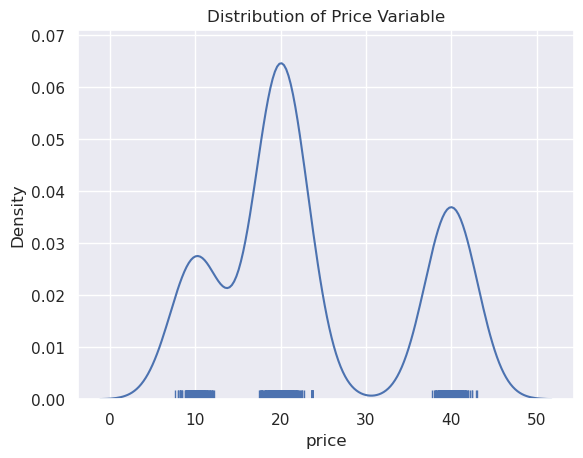

In [22]:
# plot distribution of price, noting clusters. Depending on model, may want to bin?
sns.distplot(df.price, hist=False, rug=True);
plt.title('Distribution of Price Variable');

---

### Evaluate and Clean Favorite_Flower Variable

In [23]:
# print out first few values for favorite_flower, noting that it is a categorical variable
df.favorite_flower.head()

0         iris
2    carnation
4    carnation
5      gerbera
7      gerbera
Name: favorite_flower, dtype: object

In [24]:
# print number of observations and proportion for each value
(
    pd.DataFrame()
    .assign(
        count = df.favorite_flower.value_counts(dropna=False),
        prop = df.favorite_flower.value_counts(dropna=False, normalize=True)
    )
    .style
    .format(precision=2)
)

,count,prop
nan,138,0.17
rose,106,0.13
daffodil,79,0.10
carnation,70,0.09
gardenia,61,0.08
tulip,59,0.07
gerbera,44,0.06
lilac,44,0.06
sunflower,42,0.05
orchid,42,0.05


In [25]:
# fill missing with MISSING category
df['favorite_flower'] = df.favorite_flower.fillna('MISSING')
assert df.price.isna().sum() == 0

---

## Engineer New Features

In [26]:
# create new dataframe for engineered features
dfe = pd.DataFrame()

 **NOTE**: our prediction is by family, need to collapse observations

In [27]:
# collapse rows
g = df.groupby('lastname')

### Create Mean Price

In [28]:
# get mean price per family
mean_prices = g.price.mean()
mean_prices.head()

lastname
ADAMS        38.617753
ALEXANDER    30.106511
ALLEN        26.657993
ALVAREZ      20.676235
ANDERSON     14.653257
Name: price, dtype: float64

In [29]:
dfe['mean_price'] = mean_prices

In [30]:
dfe.head()

,mean_price
lastname,
ADAMS,38.617753
ALEXANDER,30.106511
ALLEN,26.657993
ALVAREZ,20.676235
ANDERSON,14.653257


In [31]:
# depending on our model, may want to normalize features

dfe['mean_price_normed'] = (dfe.mean_price.values - dfe.mean_price.mean()) / dfe.mean_price.std()
dfe.mean_price_normed.agg(['mean','std']).round(2)

mean    0.0
std     1.0
Name: mean_price_normed, dtype: float64

In [32]:
dfe.head()

,mean_price,mean_price_normed
lastname,,
ADAMS,38.617753,1.848446
ALEXANDER,30.106511,0.823597
ALLEN,26.657993,0.408357
ALVAREZ,20.676235,-0.311913
ANDERSON,14.653257,-1.037147


In [33]:
# drop the unnormalized variable
dfe.drop('mean_price',axis=1,inplace=True)

---

### Create Favorite Flower Dummies

In [34]:
# transform favorite_flower into One Hot Encoding
flower_dummies = pd.get_dummies(df.favorite_flower, prefix='ff')
flower_dummies.head()

,ff_MISSING,ff_carnation,ff_daffodil,ff_daisy,ff_gardenia,ff_gerbera,ff_iris,ff_jasmine,ff_lilac,ff_orchid,ff_rose,ff_sunflower,ff_tulip
0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,0,0,0


In [35]:
# add the last name column using index
flower_dummies = df[['lastname']].join(flower_dummies)
flower_dummies.head()

,lastname,ff_MISSING,ff_carnation,ff_daffodil,ff_daisy,ff_gardenia,ff_gerbera,ff_iris,ff_jasmine,ff_lilac,ff_orchid,ff_rose,ff_sunflower,ff_tulip
0,PERKINS,0,0,0,0,0,0,1,0,0,0,0,0,0
2,WILLIAMSON,0,1,0,0,0,0,0,0,0,0,0,0,0
4,RHODES,0,1,0,0,0,0,0,0,0,0,0,0,0
5,NGUYEN,0,0,0,0,0,1,0,0,0,0,0,0,0
7,GRAVES,0,0,0,0,0,1,0,0,0,0,0,0,0


In [36]:
# group the flower columns by last name, aggregating by sum
flower_dummies = flower_dummies.groupby('lastname').sum()

In [37]:
# simplify by transforming count of flower into 0,1
flower_dummies = flower_dummies.applymap(lambda x: int(x > 0))

In [38]:
# join to our engineered values on lastname
dfe = dfe.join(flower_dummies)

In [39]:
dfe.head()

,mean_price_normed,ff_MISSING,ff_carnation,ff_daffodil,ff_daisy,ff_gardenia,ff_gerbera,ff_iris,ff_jasmine,ff_lilac,ff_orchid,ff_rose,ff_sunflower,ff_tulip
lastname,,,,,,,,,,,,,,
ADAMS,1.848446,0,0,0,0,0,0,0,0,0,1,0,0,0
ALEXANDER,0.823597,0,0,0,0,0,0,0,0,0,0,0,1,0
ALLEN,0.408357,0,0,0,0,0,0,0,0,0,0,1,0,0
ALVAREZ,-0.311913,0,0,0,0,0,0,0,0,0,1,0,0,0
ANDERSON,-1.037147,0,0,0,1,0,0,0,0,0,0,0,0,0


## Create Labels

In [40]:
# generate label for repeat customer
labels = df.lastname.value_counts().apply(lambda x: int(x > 1))

In [41]:
labels.head()

DANIELS     1
JACOBS      1
BURKE       1
CALDWELL    1
HUNTER      1
Name: lastname, dtype: int64

In [42]:
# join labels to engineered features
labels.name = 'reorder_label'

dfe = dfe.join(labels)

dfe.head()

,mean_price_normed,ff_MISSING,ff_carnation,ff_daffodil,ff_daisy,ff_gardenia,ff_gerbera,ff_iris,ff_jasmine,ff_lilac,ff_orchid,ff_rose,ff_sunflower,ff_tulip,reorder_label
lastname,,,,,,,,,,,,,,,
ADAMS,1.848446,0,0,0,0,0,0,0,0,0,1,0,0,0,1
ALEXANDER,0.823597,0,0,0,0,0,0,0,0,0,0,0,1,0,1
ALLEN,0.408357,0,0,0,0,0,0,0,0,0,0,1,0,0,1
ALVAREZ,-0.311913,0,0,0,0,0,0,0,0,0,1,0,0,0,0
ANDERSON,-1.037147,0,0,0,1,0,0,0,0,0,0,0,0,0,1


## Train Classifier and Evaluate

In [43]:
# get data and label column names
data_cols = dfe.columns[:-1]
label_col = dfe.columns[-1]

In [44]:
data_cols

Index(['mean_price_normed', 'ff_MISSING', 'ff_carnation', 'ff_daffodil',
       'ff_daisy', 'ff_gardenia', 'ff_gerbera', 'ff_iris', 'ff_jasmine',
       'ff_lilac', 'ff_orchid', 'ff_rose', 'ff_sunflower', 'ff_tulip'],
      dtype='object')

In [45]:
label_col

'reorder_label'

In [46]:
# importing here for demonstration
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [47]:
# split into train and test (hold out) sets (using sklearn)
X_train, X_test, y_train, y_test = train_test_split(dfe.loc[:,data_cols],
                                                    dfe.loc[:,label_col],
                                                    test_size=0.2,
                                                    stratify=dfe.loc[:,label_col])
print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}, y_train.shape = {y_test.shape}')

X_train.shape = (201, 14), y_train.shape = (201,)
X_test.shape = (51, 14), y_train.shape = (51,)


In [48]:
# perform cross validation to tune parameters (not done here)
rf = RandomForestClassifier()
cv_scores = cross_val_score(rf, X_train, y_train, cv=3)
cv_scores

array([0.7761194 , 0.74626866, 0.73134328])

In [49]:
print(f'mean cv accuracy: {np.mean(cv_scores):0.2f} +- {np.std(cv_scores)*2:0.2f}')

mean cv accuracy: 0.75 +- 0.04


In [50]:
# fit on training data and score on test
rf.fit(X_train,y_train)
print('test set accuracy: {:0.3f}'.format(rf.score(X_test,y_test)))

test set accuracy: 0.804


### Which Features are Most Important?

In [51]:
for col,fi in sorted(list(zip(data_cols,rf.feature_importances_)),key=lambda x:x[1])[::-1]:
    print(f'{col:20s} : {fi:0.3f}')

mean_price_normed    : 0.743
ff_MISSING           : 0.094
ff_sunflower         : 0.017
ff_iris              : 0.017
ff_gardenia          : 0.016
ff_daffodil          : 0.016
ff_tulip             : 0.016
ff_daisy             : 0.015
ff_rose              : 0.014
ff_carnation         : 0.013
ff_gerbera           : 0.010
ff_lilac             : 0.010
ff_jasmine           : 0.010
ff_orchid            : 0.008


### How well could we do just by guessing 1 for everyone?

In [52]:
((dfe.loc[:,label_col] == 1).sum() / len(dfe)).round(3)

0.71